In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from copy import deepcopy

from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor


from sklearn.naive_bayes import MultinomialNB

In [2]:
total_informative_features = 8
total_shit_features = 4

X = np.random.rand(total_informative_features, 50_000)
for i, cardinality in enumerate([2, 3]):
    X[i] = np.round(X[i] * cardinality * 10) % cardinality
    print(i, np.unique(X[i], return_counts=True))

for i in range(2, total_informative_features):
    X[i] = X[i] * np.random.randint(1, 10)

ys = []


def fix_row(row, pairs):
    row = row.copy()
    for fst, snd in pairs:
        row[fst], row[snd] = row[snd], row[fst]
    return row

def fix_dataset(X, pairs):
    return np.apply_along_axis(lambda x: fix_row(x, pairs),1,X)[:, :total_informative_features]  

def true_f(row, pairs=None):
    func_1 = None
    if row[0]:
        func_1 = lambda x: -x
    else:
        func_1 = lambda x: x

    func_2 = None
    if row[1] == 0:
        func_2 = lambda x: -x * x
    if row[1] == 1:
        func_2 = lambda x: x
    else:
        func_2 = lambda x: 2 * x
    return round(
        func_1(func_2(row[2] + row[3]) + row[4] * row[5]) - row[6] * row[7] + 1,
        4,
    )


for i in range(X.shape[1]):
    ys.append(true_f(X[:, i]))

0 (array([0., 1.]), array([25022, 24978]))
1 (array([0., 1., 2.]), array([16741, 16639, 16620]))


In [3]:
X.shape, X[0].copy()[np.newaxis, :].shape

((8, 50000), (1, 50000))

In [4]:
def corrupt_data(X):
    print(X.shape)
    pairs = []
    for i in range(int(X.shape[0]/2)):
        B = X[i].copy()
        X = np.concatenate((X,B.reshape(1,-1)), axis=0)
        pairs.append((i, X.shape[0] - 1))
    return X, pairs
    

In [5]:
X_corrupted, pairs = corrupt_data(X)
X_corrupted.shape

(8, 50000)


(12, 50000)

In [6]:
pairs

[(0, 8), (1, 9), (2, 10), (3, 11)]

In [7]:
len(ys), ys[0], true_f(X[:, 0])

(50000, -2.8891, -2.8891)

In [8]:
X_shit = np.random.rand(total_shit_features, 50_000)

In [9]:
X.shape

(8, 50000)

In [10]:
X_shitty = np.concatenate([X_corrupted, X_shit])
X_shitty.shape

(16, 50000)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_shitty.T, ys,test_size=0.2)

In [12]:
def corrupt_test(X_test, pairs):
    for fst, snd in pairs:
        X_test[:, fst] = X_test[:, fst] * (np.random.rand(X_test.shape[0]) < 0.2)
    return X_test

In [13]:
X_test.shape

(10000, 16)

In [14]:
X_test_corrupted = corrupt_test(X_test, pairs)

In [15]:
mean_squared_error(y_true=y_test, y_pred=np.apply_along_axis(true_f,1, X_test_corrupted)), \
mean_squared_error(y_true=y_test, y_pred=np.apply_along_axis(true_f,1, fix_dataset(X_test_corrupted, pairs))), \
mean_squared_error(y_true=y_train, y_pred=np.apply_along_axis(true_f,1, X_train))

(506.102685728656, 0.0, 0.0)

In [16]:
X_test_corrupted.shape

(10000, 16)

In [17]:
def check(clf):
    print('Raw train')
    clf = deepcopy(clf)
    print(cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', verbose=0))
    clf = deepcopy(clf)

    clf.fit(X_train, y_train)
    print('corrupted_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(X_test_corrupted)))
    print('fixed_predict',mean_squared_error(y_true=y_test, y_pred=clf.predict(np.apply_along_axis(lambda x: fix_row(x, pairs), 1, X_test_corrupted))))
    clf = deepcopy(clf)
    print('Fixed train')
    print(cross_val_score(clf, fix_dataset(X_train, pairs), y_train, scoring='neg_mean_squared_error', verbose=0))
    clf = deepcopy(clf)
    clf.fit(fix_dataset(X_train, pairs), y_train)
    print('corrupted_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(X_test_corrupted[:, :total_informative_features])))
    print('fixed_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(fix_dataset(X_test_corrupted, pairs))))

In [18]:
check(LGBMRegressor(verbose=-1))

Raw train


/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/pyth

[-3.15614779 -2.76610419 -2.7574681  -2.92623825 -2.86823172]
corrupted_predict 532.1387321414912
fixed_predict 2.745310823790937
Fixed train


/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/pyth

[-3.14941715 -2.88989516 -2.56851788 -2.83050671 -2.78373213]
corrupted_predict 531.4989000137062
fixed_predict 2.7659053970501204


/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [19]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=True))])
check(model)

Raw train


[-16.64091347 -16.68929518 -16.22210729 -16.14555363 -16.46461729]
corrupted_predict 144.44933702390293
fixed_predict 144.44933702392342
Fixed train
[-16.6096962  -16.65230545 -16.20077323 -16.10743395 -16.43486916]
corrupted_predict 495.52527428520136
fixed_predict 16.502124256488653


In [20]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=True))])
check(model)

Raw train
[-0.58772747 -0.62380102 -0.61809729 -0.59320787 -0.59549075]
corrupted_predict 170.66533252335353
fixed_predict 170.6653325233283
Fixed train
[-0.57911346 -0.61974223 -0.60978741 -0.58851287 -0.58768021]
corrupted_predict 518.3259530474745
fixed_predict 0.5786342378893891


In [21]:
check(CatBoostRegressor(verbose=0, loss_function='RMSE'))

Raw train
[-0.17447802 -0.17096464 -0.16747632 -0.17557667 -0.15942342]
corrupted_predict 110.37205947618966
fixed_predict 207.87308734175443
Fixed train
[-0.17522916 -0.16399147 -0.16403149 -0.17612748 -0.15841962]
corrupted_predict 509.4248858008999
fixed_predict 0.15144503039054819


In [22]:
check(XGBRegressor(objective='reg:squarederror'))

Raw train
[-3.43910694 -3.33046246 -3.62258244 -3.49300528 -3.34255457]
corrupted_predict 513.36279296875
fixed_predict 3.1210131645202637
Fixed train
[-3.09185433 -3.18784666 -3.36766696 -3.28011131 -3.1129179 ]
corrupted_predict 509.1087646484375
fixed_predict 2.9694905281066895


In [23]:
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=True))])
check(model)

Raw train
[-8.91158233e-10 -8.84499995e-10 -8.82496319e-10 -8.80306285e-10
 -8.63273137e-10]
corrupted_predict 227.10797304420765
fixed_predict 227.10797306724527
Fixed train
[-8.54762805e-10 -8.41917119e-10 -8.46226517e-10 -8.42913608e-10
 -8.25878779e-10]
corrupted_predict 506.1027047738405
fixed_predict 8.454681163384856e-10


In [24]:
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=True))])

In [25]:
X_train.shape

(40000, 16)

<Axes: >

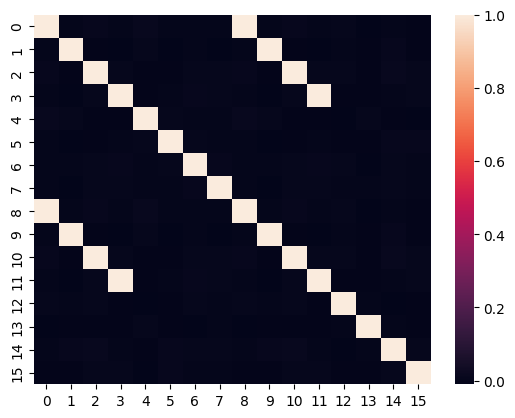

In [26]:
sns.heatmap(pd.DataFrame(X_train).corr())

<Axes: >

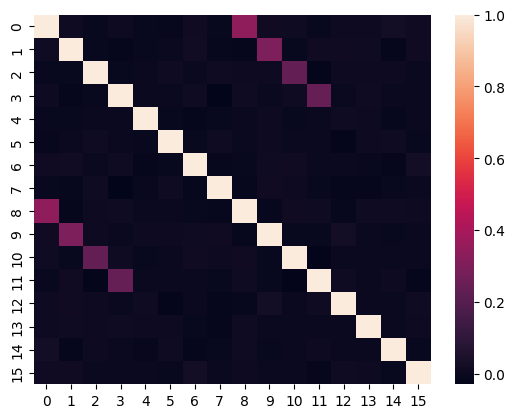

In [27]:
sns.heatmap(pd.DataFrame(X_test).corr())

In [28]:
((X_test[:, 0] - X_test[:, 8]) != 0).sum()

3943

In [29]:
X_train[:, 1]

array([1., 2., 1., ..., 0., 0., 1.])